In [17]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense, Dropout, Conv2D, MaxPool2D, 
                                     BatchNormalization, Flatten, GlobalAveragePooling2D, Input)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.applications import EfficientNetB7, MobileNetV2, VGG19, DenseNet121



In [18]:
def directory_to_df(path : str):
    df = []
    chars = 'abcdefghijklmnopqrstuvwxyz0123456789' 
    for cls in os.listdir(path):
        cls_path = os.path.join(path,cls)
        cls_name = cls.split('_')[0]
        if not cls_name in chars:
            continue
        for img_path in os.listdir(cls_path):
            direct = os.path.join(cls_path,img_path)
            df.append([direct,cls_name])
    
    df = pd.DataFrame(df, columns=['image','label'])
    print("The number of samples found:",len(df))
    return df.copy()

def read_image(path):
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def show_image(img, label=None) -> None:
  
    plt.imshow(img, cmap='gray')
    plt.axis(False)
    plt.title(label)
    plt.show()
    
def clbck(model_name):
    ERLY = EarlyStopping(patience=10, min_delta=0.01, start_from_epoch=10, verbose=1)
    RD = ReduceLROnPlateau(patience=5, min_delta=0.01, factor=0.5)
    CHK = ModelCheckpoint(f'{model_name}_model.keras', verbose=1, save_best_only=True)
    return [ERLY, RD, CHK]

In [19]:
IMG_SHAPE = (32,32)
IMG_SIZE = (32,32,3)
BATCH_SIZE = 32
opt = Adam(learning_rate=0.00001, epsilon=1e-6)
loss = 'categorical_crossentropy'
EPOCHS = 10

In [20]:
main_path = '/home/addinedu/dev_ws/data/machine/dataset'
df = directory_to_df(main_path)                   
df.head()

The number of samples found: 119929


,image,label
0,/home/addinedu/dev_ws/data/machine/dataset/t_L...,t
1,/home/addinedu/dev_ws/data/machine/dataset/t_L...,t
2,/home/addinedu/dev_ws/data/machine/dataset/t_L...,t
3,/home/addinedu/dev_ws/data/machine/dataset/t_L...,t
4,/home/addinedu/dev_ws/data/machine/dataset/t_L...,t


In [21]:
df['label'].value_counts()

label
9    3473
2    3473
0    3473
4    3473
8    3473
5    3473
7    3473
6    3473
1    3473
3    3473
r    3284
e    3284
m    3281
n    3281
a    3281
q    3279
u    3278
d    3277
i    3277
l    3276
y    3276
s    3276
t    3276
x    3276
k    3276
h    3275
w    3275
f    3275
z    3275
o    3275
p    3275
g    3275
b    3274
c    3274
j    3274
v    3274
Name: count, dtype: int64

In [22]:
X, y = df['image'], df['label']
X_train, X_test, y_train, y_test = train_test_split(X,y , test_size=0.30, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
testing_df = pd.concat((X_test,y_test), axis=1)

In [23]:
X, y = training_df['image'], training_df['label']
X_train, X_valid, y_train, y_valid = train_test_split(X,y , test_size=0.25, random_state=41)
training_df = pd.concat((X_train,y_train), axis=1)
validation_df = pd.concat((X_valid,y_valid), axis=1)

In [24]:
# Creating generators
gen = ImageDataGenerator(dtype=np.int32, brightness_range=[0.0,1.0], fill_mode='nearest')
gen2 = ImageDataGenerator(dtype=np.int32, fill_mode='nearest')
train_gen = gen.flow_from_dataframe(training_df, x_col='image',y_col='label', batch_size=BATCH_SIZE, 
                                   target_size=IMG_SHAPE)
valid_gen = gen2.flow_from_dataframe(validation_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                        target_size=IMG_SHAPE, shuffle=False)
test_gen = gen2.flow_from_dataframe(testing_df, x_col='image', y_col='label', batch_size=BATCH_SIZE, 
                                       target_size=IMG_SHAPE, shuffle=False)

Found 62962 validated image filenames belonging to 36 classes.
Found 20988 validated image filenames belonging to 36 classes.
Found 35979 validated image filenames belonging to 36 classes.


In [25]:
mapping = train_gen.class_indices
mapping_inverse = dict(map(lambda x: tuple(reversed(x)), mapping.items()))

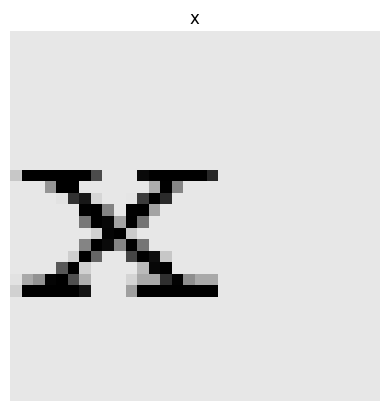

The shape of the image: (32, 32, 3)


In [26]:
BATCH_NUM = 10
IMG_NUM = 2      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

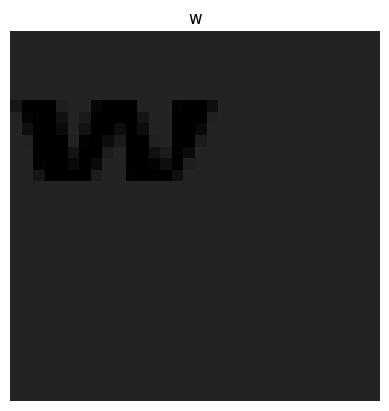

The shape of the image: (32, 32, 3)


In [27]:
BATCH_NUM = 65
IMG_NUM = 30      # from 0 to 31
show_image(train_gen[BATCH_NUM][0][IMG_NUM],mapping_inverse[train_gen[BATCH_NUM][1][IMG_NUM].argmax()])
print('The shape of the image:',train_gen[BATCH_NUM][0][IMG_NUM].shape)

In [28]:
CNN_model = Sequential()
CNN_model.add(Input(shape=IMG_SIZE, batch_size=BATCH_SIZE, name='Input'))
CNN_model.add(Conv2D(3, (3,3), strides=1, activation='relu', padding='same'))
CNN_model.add(Conv2D(128, (3,3), activation='relu'))
CNN_model.add(MaxPool2D((3,3)))
CNN_model.add(Conv2D(256, (3,3), activation='relu'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(256, (3,3), strides=2, activation='relu', padding='same'))
CNN_model.add(MaxPool2D((2,2)))
CNN_model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
CNN_model.add(Dropout(0.2))
CNN_model.add(Conv2D(1024, (2,2), activation='relu', padding='same'))
CNN_model.add(MaxPool2D(2,2))
CNN_model.add(Flatten())
CNN_model.add(Dense(1024, activation='selu'))
CNN_model.add(Dense(len(mapping), activation='softmax'))

In [29]:
CNN_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (32, 32, 32, 3)        │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (32, 30, 30, 128)      │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 10, 10, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (32, 8, 8, 256)        │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 8, 8, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (32, 4, 4, 256)        │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 2, 2, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (32, 2, 2, 512)        │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 2, 2, 512)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (32, 2, 2, 1024)       │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 1, 1, 1024)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (32, 1024)             │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (32, 36)               │        36,900 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,253,752 (20.04 MB)

 Trainable params: 5,253,752 (20.04 MB)

 Non-trainable params: 0 (0.00 B)

In [30]:
CNN_model.compile(optimizer=Adam(), loss=loss, metrics=['accuracy'])

In [31]:
history = CNN_model.fit(train_gen, epochs=20, validation_data=valid_gen, callbacks=clbck("CustomCnn"))

Epoch 1/20


/home/addinedu/venv/opencv2_venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1715329446.861815  145851 service.cc:145] XLA service 0x781fec002070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715329446.861839  145851 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-05-10 17:24:06.912141: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-10 17:24:07.186008: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024

  15/1968 ━━━━━━━━━━━━━━━━━━━━ 22s 12ms/step - accuracy: 0.0171 - loss: 7.6860  

I0000 00:00:1715329451.812964  145851 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1968/1968 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4341 - loss: 2.1575
Epoch 1: val_loss improved from inf to 0.54930, saving model to CustomCnn_model.keras
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 39s 16ms/step - accuracy: 0.4343 - loss: 2.1570 - val_accuracy: 0.8467 - val_loss: 0.5493 - learning_rate: 0.0010
Epoch 2/20
1964/1968 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8477 - loss: 0.5586
Epoch 2: val_loss improved from 0.54930 to 0.44488, saving model to CustomCnn_model.keras
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.8477 - loss: 0.5585 - val_accuracy: 0.8919 - val_loss: 0.4449 - learning_rate: 0.0010
Epoch 3/20
1966/1968 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.8718 - loss: 0.4694
Epoch 3: val_loss improved from 0.44488 to 0.43527, saving model to CustomCnn_model.keras
1968/1968 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.8718 - loss: 0.4694 - val_accuracy: 0.8930 - val_loss: 0.4353 - learning_rate: 0.0010
Epoch 4/20
1965/1968 ━━━━━━━━━━━━━━━━━━━━ 0

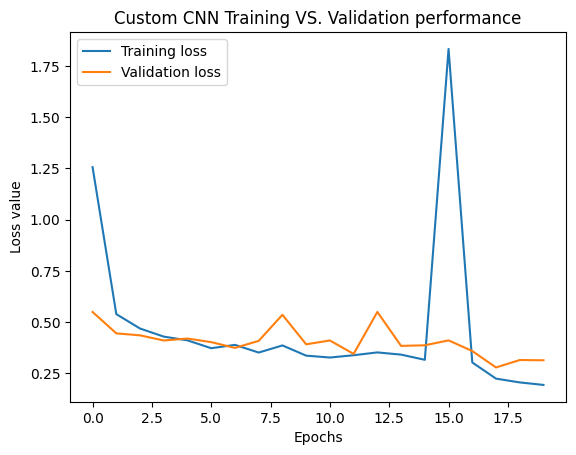

In [32]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss value')
plt.title("Custom CNN Training VS. Validation performance")
plt.show()

In [33]:
# Making a prediction out of the Custom CNN for the testing set for the evaluation
prediction = CNN_model.predict(test_gen)
pred = list(map(lambda x: mapping_inverse[np.argmax(x)], prediction))
y_test = list(map(lambda x: mapping_inverse[x],test_gen.classes))

print('\t\tThe Custom CNN Evaluation Performance')
print(classification_report(y_test, pred))

1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step
		The Custom CNN Evaluation Performance
              precision    recall  f1-score   support

           0       0.90      0.82      0.86      1043
           1       0.88      0.88      0.88      1017
           2       0.97      0.92      0.95      1048
           3       0.98      0.91      0.94      1034
           4       0.78      0.95      0.86      1056
           5       0.94      0.92      0.93      1035
           6       0.98      0.91      0.95      1032
           7       0.97      0.94      0.96      1044
           8       0.94      0.91      0.93       982
           9       0.93      0.93      0.93      1072
           a       0.92      0.94      0.93       953
           b       0.96      0.96      0.96       978
           c       0.88      0.96      0.92       990
           d       0.99      0.93      0.96       949
           e       0.95      0.91      0.93       970
           f       0.97      0.97      0.97       96

In [47]:
def load_model():
    model_path = '/home/addinedu/dev_ws/DL/CustomCnn_model.keras'
    model = tf.keras.models.load_model(model_path)
    return model


def convert_2_gray(image):
    gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return gray_image

def binarization(image):
    img, thresh = cv2.threshold(image, 0,255, cv2.THRESH_OTSU|cv2.THRESH_BINARY_INV)
    return img, thresh

def dilate(image, words= False):
    img = image.copy()
    m = 3
    n = m - 2                   
    itrs = 4
    if words:
        m = 6
        n = m
        itrs = 3
    rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (n, m))
    dilation = cv2.dilate(img, rect_kernel, iterations = itrs)
    return dilation

def find_rect(image):
    contours, hierarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    rects = []
    
    for cnt in contours:
        x,y,w,h = cv2.boundingRect(cnt)  
        rects.append([x,y,w,h])
        
    sorted_rects = list(sorted(rects, key=lambda x: x[0])) 
    return sorted_rects

def extract(image):
    model = load_model()
    chars = []              # a list to store recognized characters
    
    image_cpy = image.copy()
    _, bin_img = binarization(convert_2_gray(image_cpy))
    full_dil_img = dilate(bin_img,words=True)
    words = find_rect(full_dil_img)                       # Recognized words within the image 
    del _, bin_img, full_dil_img                          # for better memory usage
    
    for word in words:
        x,y,w,h = word                                    # coordinates of the word
        img = image_cpy[y:y+h, x:x+w]
        
        _, bin_img = binarization(convert_2_gray(img))
        dil_img = dilate(bin_img)
        char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
        cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
        del _, bin_img, dil_img
        
        for char in char_parts:    
            x,y,w,h = char
            ch = img[y:y+h, x:x+w]
            
            empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
            x,y = 3,3                                          # starting indecies
            resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
            gray = convert_2_gray(resized)
            empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
            gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
            gray = gray.astype(np.int32)
            
            predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
            chars.append(predicted)                            # append the character into the list
            
            del ch, resized, gray, empty_img
        chars.append(' ')  # at the end of each iteration (end of word) append a space
        
    del model
    show_image(image)
    return ''.join(chars[:-1])
# def extract(image):
#     model = load_model()  # 모델 로드
#     chars = []              # a list to store recognized characters
    
#     image_cpy = image.copy()
#     _, bin_img = binarization(convert_2_gray(image_cpy))
#     full_dil_img = dilate(bin_img,words=True)
#     words = find_rect(full_dil_img)                       # Recognized words within the image 
#     del _, bin_img, full_dil_img                          # for better memory usage
    
#     for word in words:
#         x,y,w,h = word                                    # coordinates of the word
#         img = image_cpy[y:y+h, x:x+w]
        
#         _, bin_img = binarization(convert_2_gray(img))
#         dil_img = dilate(bin_img)
#         char_parts = find_rect(dil_img)                     # Recognized chars withtin the word
#         cv2.rectangle(image, (x,y),(x+w,y+h), (0,255,0), 3) # draw a green rectangle around the word
        
#         del _, bin_img, dil_img
        
#         for char in char_parts:    
#             x,y,w,h = char
#             ch = img[y:y+h, x:x+w]
            
#             empty_img = np.full((32,32,1),255, dtype=np.uint8) # a white image used for resize with filling
#             x,y = 3,3                                          # starting indecies
#             resized = cv2.resize(ch, (16,22), interpolation=cv2.INTER_CUBIC)
#             gray = convert_2_gray(resized)
#             empty_img[y:y+22, x:x+16,0] = gray.copy()          # integrate the recognized char into the white image
#             gray = cv2.cvtColor(empty_img, cv2.COLOR_GRAY2RGB)
#             gray = gray.astype(np.int32)
            
#             predicted = mapping_inverse[np.argmax(model.predict(np.array([gray]), verbose=-1))]
#             chars.append(predicted)                            # append the character into the list
            
#             del ch, resized, gray, empty_img
#         chars.append(' ')  # at the end of each iteration (end of word) append a space
        
#     del model
#     show_image(image)
#     return ''.join(chars[:-1])


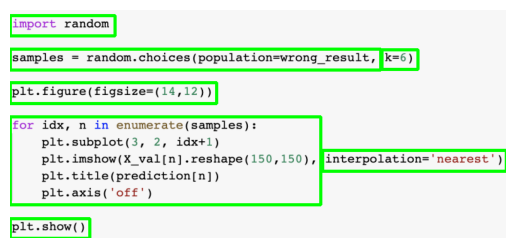

--> pltmshw13 e0rppbpidlllltttxttmmrvtaismxumiitsbp5lhiwe1nt0lh0ptetrxnetheuc3dvmvhiae3cl2rtatrint0ie1dn1vxr5rne4wsl4h33alpee5t3ll50vl503v pltneigureteig5izesql4v1233 swleszrandomnch0ices1p0pulati0nswr0ny3resultr iw0rtranhm interp0lati0nshnearesth7 kz63


In [48]:
img = read_image('/home/addinedu/Pictures/Screenshots/Screenshot from 2024-05-10 17-39-42.png')
text = extract(img)
print('-->',text)